In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import xgboost as xgb

In [20]:
# 1. Feature extractors
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_combined_features(image):
    return np.hstack([
        extract_hog_features(image),
        extract_color_histogram(image),
        extract_lbp_features(image)
    ])


In [ ]:
# 2. Load and preprocess dataset
data_dir = "/kaggle/input/dataset"
categories = os.listdir(data_dir)

X, y = [], []
for label in categories:
    folder_path = os.path.join(data_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, (128, 128))
            features = extract_combined_features(image)
            X.append(features)
            y.append(label)

X = np.array(X)
y = np.array(y)


In [22]:
# 3. Encode labels and normalize
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# 4. PCA for dimensionality reduction
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

In [24]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [25]:
# 6. Ensemble classifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42)
svm = SVC(kernel='rbf', C=10, probability=True)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', learning_rate=0.05)

ensemble = VotingClassifier(estimators=[
    ('rf', rf), ('svm', svm), ('xgb', xgb_model)
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [26]:
# 7. Evaluation
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy: 0.5607476635514018

📄 Classification Report:

              precision    recall  f1-score   support

         cat       0.52      0.55      0.53        22
         cow       0.53      0.40      0.46        20
         dog       0.47      0.38      0.42        21
        lamb       0.63      0.77      0.69        22
       zebra       0.60      0.68      0.64        22

    accuracy                           0.56       107
   macro avg       0.55      0.56      0.55       107
weighted avg       0.55      0.56      0.55       107



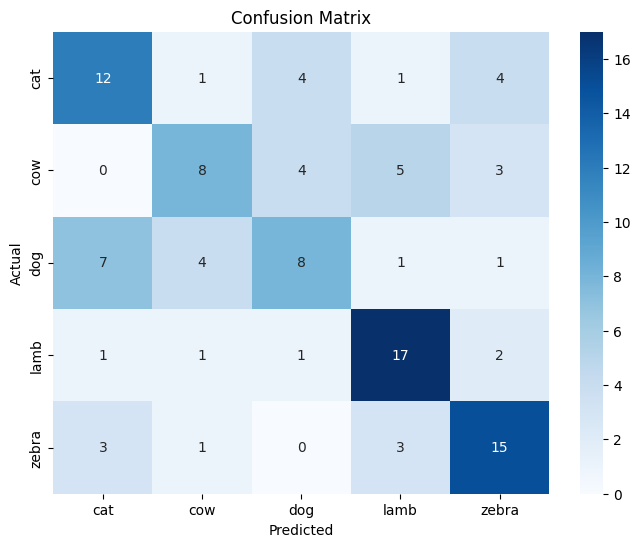

In [27]:
# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()